<a href="https://colab.research.google.com/github/amalp12/MLAI/blob/main/CycleGAN_Edge2Shoe_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [2]:
import tarfile
from google.colab.patches import cv2_imshow
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pdb # python debugger https://web.stanford.edu/class/physics91si/2013/handouts/Pdb_Commands.pdf
import torchvision.transforms as transforms

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/edges2shoes.tar.gz

--2021-06-19 04:39:03--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/edges2shoes.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2165283376 (2.0G) [application/x-gzip]
Saving to: ‘edges2shoes.tar.gz’

edges2shoes.tar.gz  100%[===================>]   2.02G   978KB/s    in 18m 47s 

2021-06-19 04:57:50 (1.83 MB/s) - ‘edges2shoes.tar.gz’ saved [2165283376/2165283376]



In [ ]:
tf = tarfile.open("/content/edges2shoes.tar.gz")
tf.extractall('/content/drive/MyDrive')

**Initializing Hyperparameters**

In [4]:
batch_size = 32
epochs = 1000
lambda_ = 10
learning_rate = 10e-4
image_channels = 3
image_size = 256

**Getting Data**

This image is:  <class 'numpy.ndarray'> with dimensions: (256, 512, 3)
This image is:  <class 'numpy.ndarray'> with dimensions: (256, 256, 3)
This image is:  <class 'numpy.ndarray'> with dimensions: (256, 256, 3)


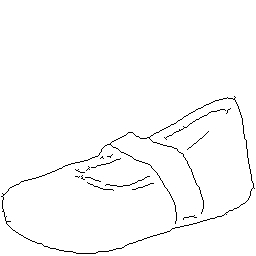

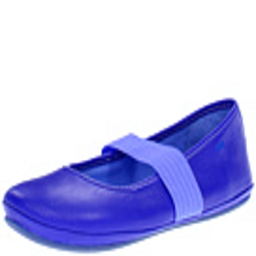

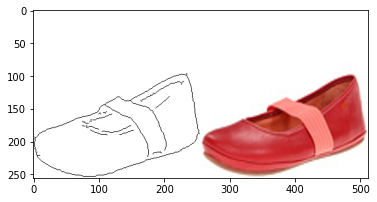

In [13]:
folder_path = "/content/drive/MyDrive/edges2shoes/train"
all_train = os.listdir(folder_path)
test_sample = random.sample(all_train, batch_size)
img_path =  folder_path+"/"+test_sample[0]

img = mpimg.imread(img_path)
print('This image is: ',type(img), 
     'with dimensions:', img.shape)
plt.imshow(img)
edge_img, label_img = np.split(img,2, axis=1)

print('This image is: ',type(edge_img), 
     'with dimensions:', edge_img.shape)

print('This image is: ',type(label_img), 
     'with dimensions:', label_img.shape)

cv2_imshow(edge_img)
cv2_imshow(label_img)

**Functions**


Edges:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)


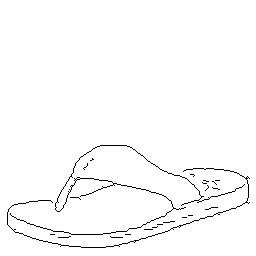

Label :


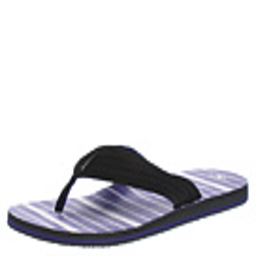

In [14]:
def normalize(x):
  # Denormalizeing 
  pixels = ((x/255)-.5)/.5
  return pixels
def denormalize(x):
  # Denormalizeing 
  pixels =  ((x *.5)+.5)*255
  return pixels

def sample(batchsize):
  folder_path = "/content/drive/MyDrive/edges2shoes/train"
  all_train = os.listdir(folder_path)
  train_data =[]
  label_data =[]
  
  train_sample = random.sample(all_train, batch_size)
  for j in range(batchsize):
    image_path =  folder_path+"/"+ train_sample[j]
    image = mpimg.imread(image_path)
    edge_image, label_image = np.split(image,2, axis=1)
    edge_image = torch.from_numpy(edge_image)
    label_image = torch.from_numpy(label_image)
    train_data.append(edge_image)
    label_data.append(label_image)
  
  train_data = torch.stack(train_data).reshape(batchsize, 3, 256, 256).to(torch.float) # E
  label_data = torch.stack(label_data).reshape(batchsize, 3, 256, 256).to(torch.float) # S
  return (train_data, label_data)
def testSample():
    t,l = sample(1)
    print("Edges:")
    cv2_imshow(t.detach().numpy().reshape(256, 256, 3))
    print("Label :")
    cv2_imshow(l.detach().numpy().reshape(256, 256, 3))
testSample()

**Using GPU**

In [8]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


**Loss Functions**

Adveserial Loss

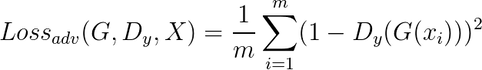

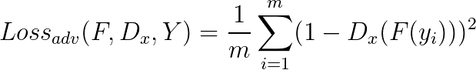

In [15]:
def advLoss(batchsize,D_of_G_of_x):
  l= (1/batchsize)*(1-D_of_G_of_x)**2
  return l.sum()

L1 = nn.L1Loss() #for cycle loss
    




 cycle consistency loss

 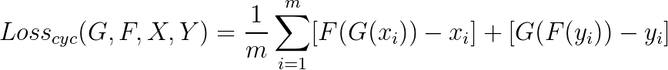

In [16]:
def cycLoss(G2_of__G1_of_E,E , batchsize):
  l = (1/batchsize)*((G2_of__G1_of_E - E))
  return l.sum()

mse = nn.MSELoss() # for disc loss
  

**Generator**

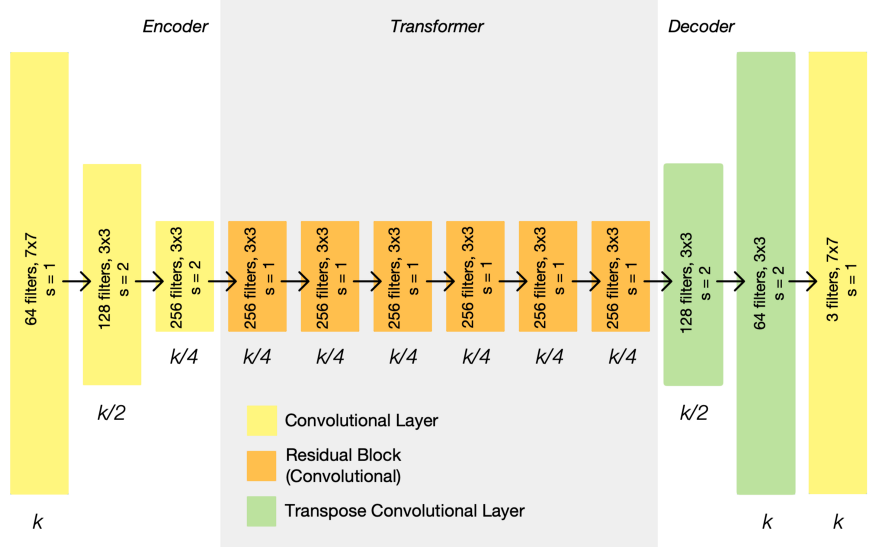

An architecture for a CycleGAN generator. As you can see above, the representation size shrinks in the encoder phase, stays constant in the transformer phase, and expands again in the decoder phase. The representation size that each layer outputs is listed below it, in terms of the input image size, k. On each layer is listed the number of filters, the size of those filters, and the stride. Each layer is followed by an instance normalization and ReLU activation.

In [9]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

def testG():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    print(gen(x).shape)
testG()
gen1 = Generator(image_channels ,9).to(device)
gen2 = Generator(image_channels,9).to(device)

torch.Size([2, 3, 256, 256])


**Discriminator**
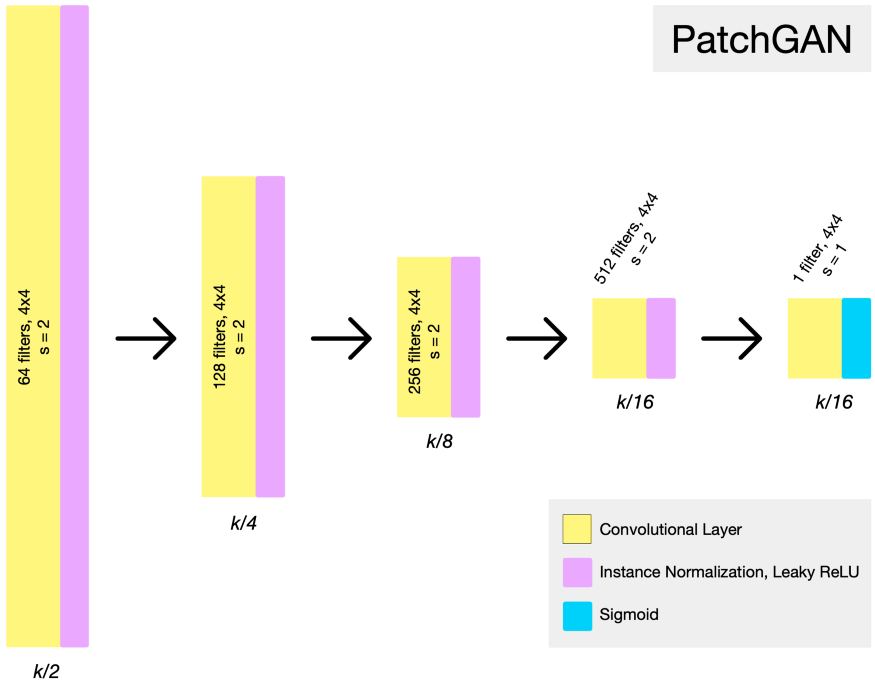


An example architecture for a PatchGAN discriminator. PatchGAN is a fully convolutional network, that takes in an image, and produces a matrix of probabilities, each referring to the probability of the corresponding “patch” of the image being “real” (as opposed to generated). The representation size that each layer outputs is listed below it, in terms of the input image size, k. On each layer is listed the number of filters, the size of those filters, and the stride.

In [10]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

def testD():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(preds.shape)




testD()
disc1= Discriminator().to(device)
disc2= Discriminator().to(device)

torch.Size([5, 1, 30, 30])


**Training**


Epoch : 0
Real:


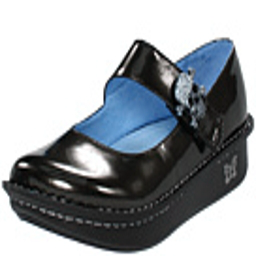

Generated:


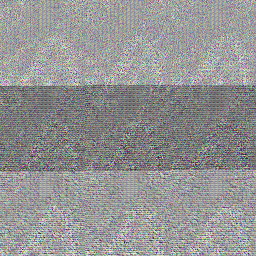

Loss : 10950.655
Epoch : 5
Real:


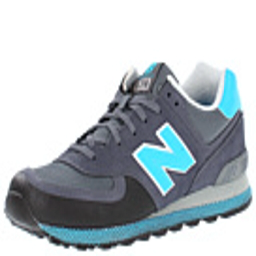

Generated:


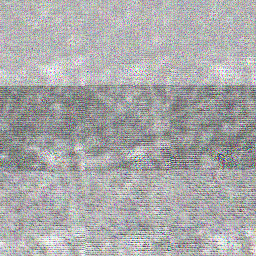

Loss : 7276.9644
Epoch : 10
Real:


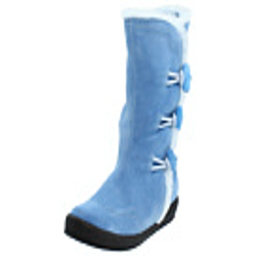

Generated:


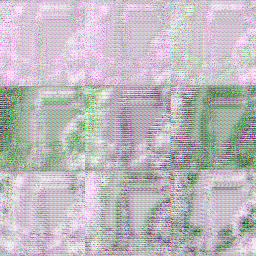

Loss : 5610.2417
Epoch : 15
Real:


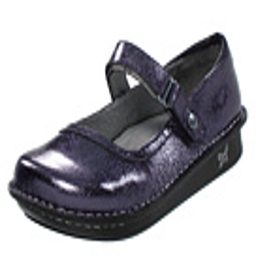

Generated:


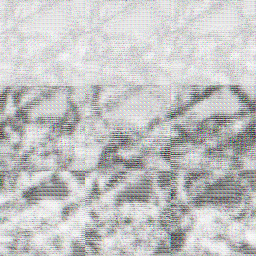

Loss : 10214.392
Epoch : 20
Real:


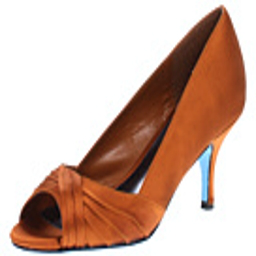

Generated:


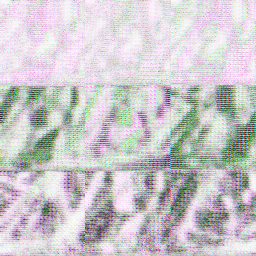

Loss : 9631.476
Epoch : 25
Real:


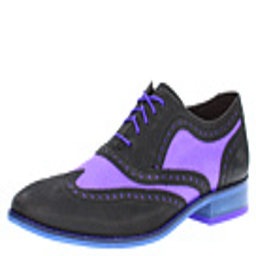

Generated:


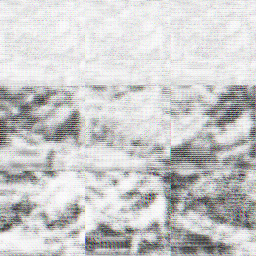

Loss : 8166.83
Epoch : 30
Real:


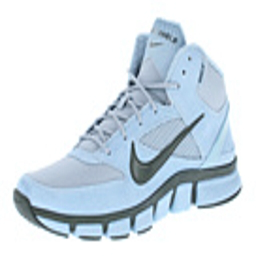

Generated:


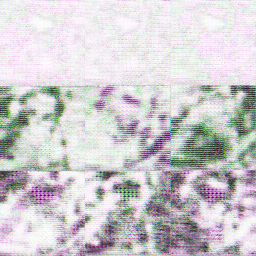

Loss : 4306.643
Epoch : 35
Real:


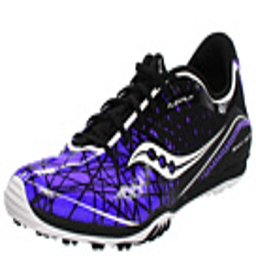

Generated:


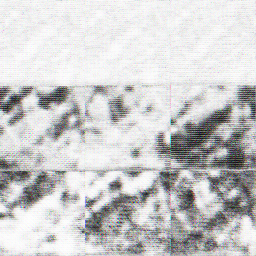

Loss : 12258.907
Epoch : 40
Real:


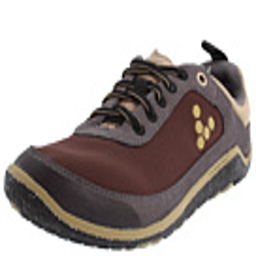

Generated:


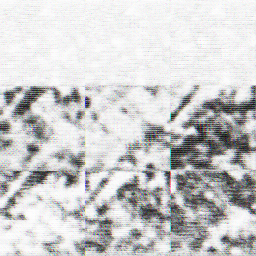

Loss : 10322.03
Epoch : 45
Real:


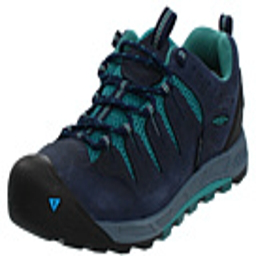

Generated:


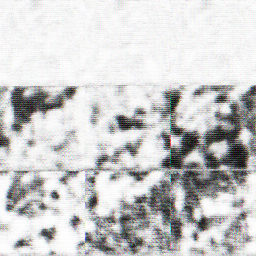

Loss : 16464.15
Epoch : 50
Real:


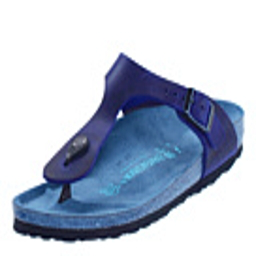

Generated:


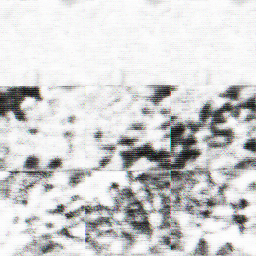

Loss : 7756.8745
Epoch : 55
Real:


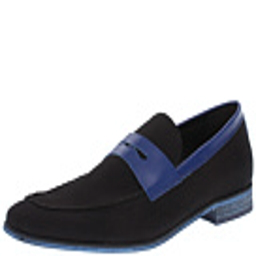

Generated:


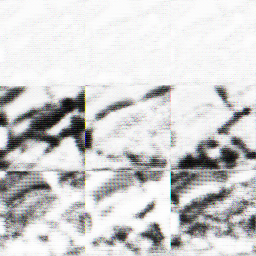

Loss : 11872.1875
Epoch : 60
Real:


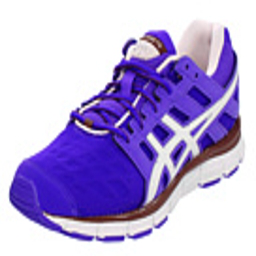

Generated:


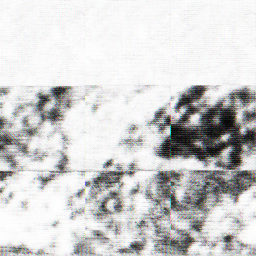

Loss : 10484.921
Epoch : 65
Real:


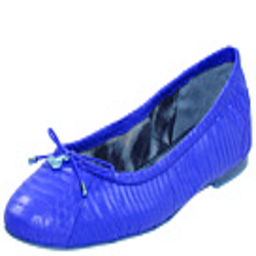

Generated:


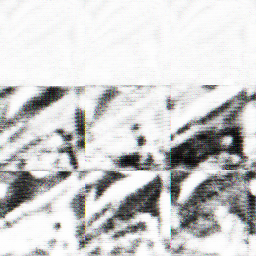

Loss : 9158.882
Epoch : 70
Real:


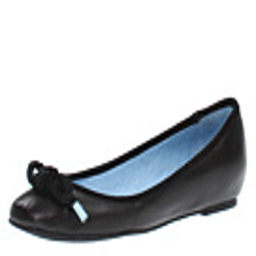

Generated:


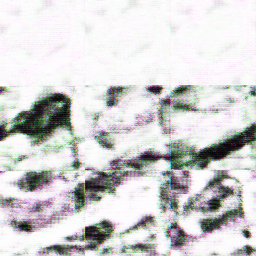

Loss : 8640.827
Epoch : 75
Real:


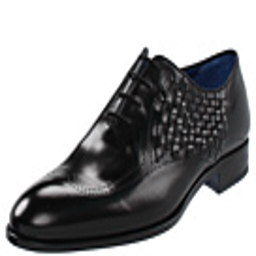

Generated:


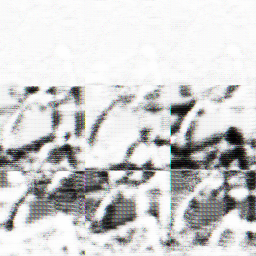

Loss : 13892.894
Epoch : 80
Real:


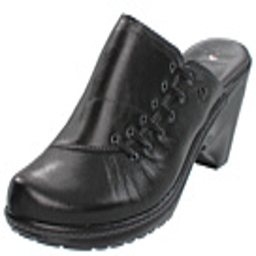

Generated:


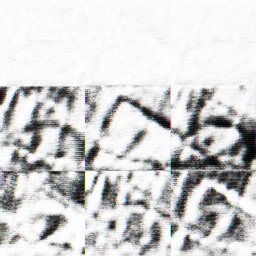

Loss : 15040.785
Epoch : 85
Real:


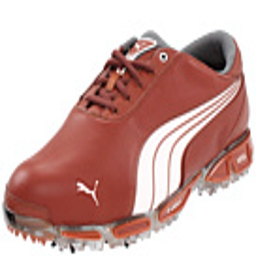

Generated:


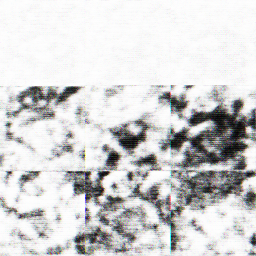

Loss : 9195.99
Epoch : 90
Real:


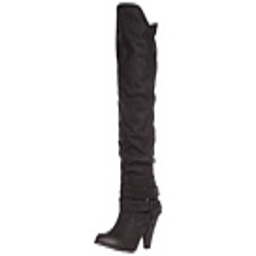

Generated:


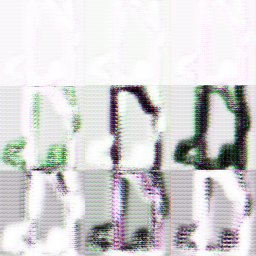

Loss : 7752.3325
Epoch : 95
Real:


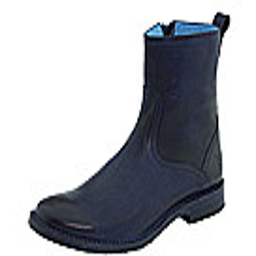

Generated:


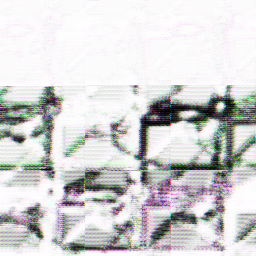

Loss : 11098.496
Epoch : 100
Real:


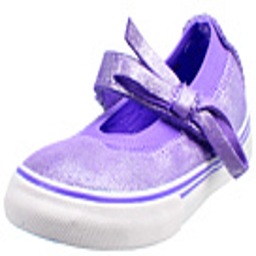

Generated:


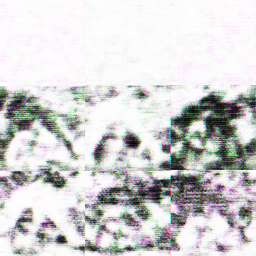

Loss : 6605.756
Epoch : 105
Real:


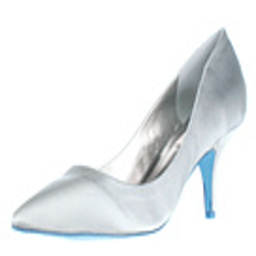

Generated:


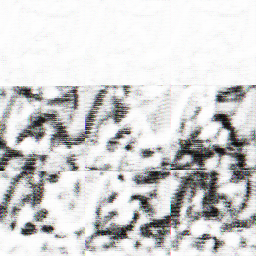

Loss : 5172.7324
Epoch : 110
Real:


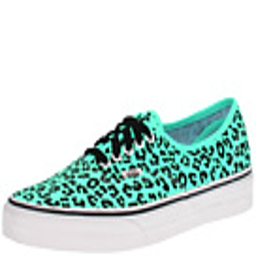

Generated:


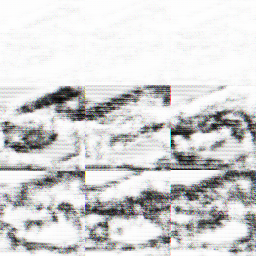

Loss : 5939.8984
Epoch : 115
Real:


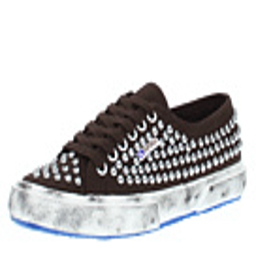

Generated:


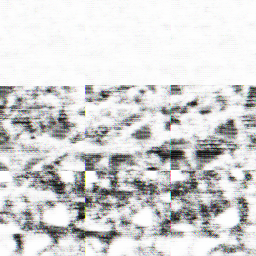

Loss : 6626.467


In [ ]:
disc_optim = optim.Adam(list(disc1.parameters())+list(disc2.parameters() )  , lr=0.001,betas=(0.5, 0.999))
gen_optim = optim.Adam(list(gen1.parameters())+list(gen2.parameters() )  ,lr=0.0003,betas=(0.5, 0.999) )

for epoch in range(epochs):
  

  
  # randomly samples data of size [ batch_size , 3, 256, 256]
  train_data ,  label_data = sample(batch_size)
  #pdb.set_trace()
  # Normalize to from 0-255 to -1 to 1
  train_data =  normalize(train_data.detach()).to(device)
  label_data = normalize(label_data.detach()).to(device)
  
  g1_of_e = gen1(train_data) # inputed real, outputs of g1
  g2_of_s = gen2(label_data) # inputed real, outputs of g2
  g1_of_g2_of_s = gen1(g2_of_s) # inputed fakes , outputs of g1
  g2_of_g1_of_e = gen2(g1_of_e) # inputed fakes, outputs of g2
  
  ### train disc1
  
  
  d1_of_s = disc1(label_data) # inputed real, outputs of disc1
  d1_of_g1_of_e = disc1(g1_of_e.detach() )# inputed fakes, outputs of dic1 # repeat again for gen
  

  disc1_real_loss = mse(d1_of_s,torch.ones_like(d1_of_s) ) # making disc attain 1 for real inputs 
  disc1_fake_loss =  mse(d1_of_g1_of_e, torch.zeros_like(d1_of_g1_of_e)) # making disc attain 0 for fake inputs

  disc1_loss = (disc1_real_loss+disc1_fake_loss)/2
  
  
  ### train disc2
  
  
  d2_of_e = disc2(train_data) # inputed real, outputs of dic2
  d2_of_g2_of_s = disc2(g2_of_s.detach())  # inputed fakes, outputs of dic2 # repeat again for gen

  disc2_real_loss = mse(d2_of_e,torch.ones_like(d2_of_e) ) # making disc attain 1 for real inputs
  disc2_fake_loss =  mse(d2_of_g2_of_s, torch.zeros_like(d2_of_g2_of_s)) # making disc attain 0 for fake inputs


  disc2_loss = (disc2_real_loss+disc2_fake_loss)/2
  
  ## step both desc together

  disc_loss = (disc1_loss + disc2_loss)/2
  disc_optim.zero_grad()
  disc_loss.backward()
  disc_optim.step()
  ########################################################################################################################

  d1_of_g1_of_e = disc1(g1_of_e)
  d2_of_g2_of_s = disc2(g2_of_s)
  ### Train G1

  gen1_loss = mse(d1_of_g1_of_e,torch.ones_like(d1_of_g1_of_e) )


 

  ### Train G2
  

  gen2_loss = mse(d2_of_g2_of_s,torch.ones_like(d2_of_g2_of_s) )

  


  ### Train G1 --> G2
  

  
  
  cyc_loss_g1 = L1(g2_of_g1_of_e, train_data )
  g1_to_g2_loss = gen1_loss + lambda_ *cyc_loss_g1
  



  ### Train G2 --> G1
  
  #pdb.set_trace()
  
  cyc_loss_g2 = L1(  g1_of_g2_of_s, label_data )
  g2_to_g1_loss = gen2_loss +lambda_*cyc_loss_g2

  # Stepping both generators together:
  gen_optim.zero_grad()
  gen_loss = gen1_loss + gen2_loss + g1_to_g2_loss + g2_to_g1_loss
  gen_loss.backward()
  gen_optim.step()

     
  if epoch%5==0:
    t,l = sample(1)
    true = l
    generated = denormalize(gen1(t))
    loss = mse(generated, true)
    print('Epoch :',epoch)
    print("Real:")
    cv2_imshow(true.detach().numpy().reshape(256, 256, 3))
    print("Generated:")
    cv2_imshow(generated.detach().numpy().reshape(256, 256, 3))
    print('Loss :',loss.detach().numpy()) 


torch.Size([1, 3, 256, 256])
Real:


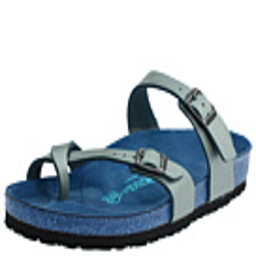

Generated:


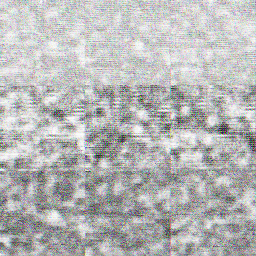

In [ ]:
t,l = sample(1)        
true = l     
generated = denormalize(gen1(t))     
print(generated.shape)
print("Real:")  
cv2_imshow(true.detach().numpy().reshape(256, 256, 3))   
print("Generated:")  
cv2_imshow(generated.detach().numpy().reshape(256, 256, 3)) 
